# 1. Chargement du dataset

In [1]:
csv_pvf10 = "../data/processed/structure_pvf_10.csv"

In [2]:
import pandas as pd
import numpy as np

# Charger le dataframe à partir du dataset
def load_df_from_dataset(csv_path,ensemble,format):
    # Charger le fichier CSV
    df_pvf10 = pd.read_csv(csv_path)
    # Filtrer par ensemble (train/test) et par format
    df_pvf10 = df_pvf10.loc[(df_pvf10['Train_Test'] == ensemble) & (df_pvf10['Format'] == format)]   
    return df_pvf10

# Chargement dataframes d'entraînement et de test
df_train = load_df_from_dataset(csv_pvf10, 'train','110x60')
df_test = load_df_from_dataset(csv_pvf10, 'test','110x60')

# Séparation features / cible
X_train = df_train.drop('Classe',axis=1)
y_train = df_train['Classe']
X_test = df_test.drop('Classe',axis=1)
y_test = df_test['Classe']

# 2. Définition de transformeurs pour extraction de features

### Transformeur 1 : vecteurs HOG

In [3]:
import cv2
from skimage.feature import hog
from sklearn.base import BaseEstimator, TransformerMixin

# Transformeur qui renvoie le dataframe des vecteurs HOG
class HOGExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, image_size=(60,110), pixels_per_cell=(8,8),cells_per_block=(2,2)):
        self.image_size = image_size
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.feature_names_ = None

    # Méthode d'extraction du vecteur HOG d'une image
    def extract_hog(self, gray_img):
        hog_vector = hog(
            gray_img,
            orientations=9,
            pixels_per_cell=self.pixels_per_cell,
            cells_per_block=self.cells_per_block,
            feature_vector=True
        )
        return hog_vector
    
    # Le fit ne sert qu'à récupérer le nom des features créées
    def fit(self, X, y=None):
        # On utilise une seule image
        img = cv2.imread(X['Chemin'].iloc[0])
        # Conversion en niveaux de gris et resizing
        img_gray_resized = cv2.cvtColor(cv2.resize(img, self.image_size), cv2.COLOR_BGR2GRAY)
        # Extraction du vecteur HOG
        hog_vector = self.extract_hog(img_gray_resized)
        # On en déduit le nom des features
        self.feature_names_ =  [f'HOG_{i+1}' for i in range(len(hog_vector))]
        return self
    
    def transform(self, X):
        # On va calculer les vecteurs HOG
        hog_vectors = []
        # On parcourt les chemins des images
        for img_path in X['Chemin']:
            # Lecture de l'image
            img = cv2.imread(img_path)
            # Conversion en niveaux de gris et resizing
            img_gray_resized = cv2.cvtColor(cv2.resize(img, self.image_size), cv2.COLOR_BGR2GRAY)
            # Extraction et stockage du vecteur HOG
            hog_vector = self.extract_hog(img_gray_resized)
            hog_vectors.append(hog_vector)
        # On renvoie le dataframe des vecteurs HOG
        return pd.DataFrame(hog_vectors,index=X.index,columns=self.feature_names_)
    
    # Pour récupération du nom des features créées
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_

### Transformeur 2 : vecteurs GLCM 

In [4]:
from skimage.feature import graycomatrix, graycoprops

# Transformeur qui renvoie le dataframe des caractéristiques GLCM
class GLCMExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, image_size=(60,110),
                 glcm_distances=[1],
                 glcm_angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                 glcm_props=['contrast','dissimilarity','homogeneity','energy','correlation']):
        self.image_size = image_size
        self.glcm_distances = glcm_distances
        self.glcm_angles = glcm_angles
        self.glcm_props = glcm_props
        # On détermine le nom des features GLCM à extraire
        self.feature_names_ = []
        # Pour chaque propriété, chaque distance et chaque angle
        for prop in self.glcm_props:
            for distance in self.glcm_distances:
                for angle in self.glcm_angles:
                    # On stocke dans les noms des features un label du type : contrast_d1_a45
                    self.feature_names_.append(f"{prop}_d{distance}_a{np.degrees(angle):.0f}")

    # Méthode d'extraction des caractéristiques GLCM d'une image
    def extract_glcm(self, gray_img):
        glcm_vector = []
        # Calcul de la matrice GLCM (256 x 256 x distances x angles)
        glcm = graycomatrix(
            gray_img,
            distances=self.glcm_distances,
            angles=self.glcm_angles,
            levels=256
        )
        # Pour chaque propriété GLCM
        for prop in self.glcm_props:
            # On la calcule pour les différentes distances et les différents angles 
            prop_matrix = graycoprops(glcm, prop)  # Matrice distances x angles
            # On transforme la matrice en vecteur qu'on stocke dans glcm_vector
            glcm_vector.extend(prop_matrix.flatten())
        return glcm_vector      

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # On va calculer les vecteurs GLCM
        glcm_vectors = []
        # On parcourt les chemins des images
        for img_path in X['Chemin']:
            # Lecture de l'image
            img = cv2.imread(img_path)
            # Conversion en niveaux de gris et resizing
            img_gray_resized = cv2.cvtColor(cv2.resize(img, self.image_size), cv2.COLOR_BGR2GRAY)
            # Extraction et stockage du vecteur GLCM
            glcm_vector = self.extract_glcm(img_gray_resized)
            glcm_vectors.append(glcm_vector)
        # On renvoie le dataframe des vecteurs GLCM
        return pd.DataFrame(glcm_vectors,index=X.index,columns=self.feature_names_)
    
    # Pour récupération du nom des features créées
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_

### Transformeur 3 : vecteurs Entropie

In [5]:
from skimage.filters.rank import entropy
from skimage.morphology import disk
from scipy.stats import skew, kurtosis

# Transformeur qui renvoie le dataframe des caractéristiques de l'entropie
class EntropyExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, image_size=(60,110),radius=4, bins=10, include_histogram=True):
        self.image_size = image_size
        self.radius = radius
        self.bins = bins
        self.include_histogram = include_histogram
        # On détermine le nom des features Entropie à extraire
        self.feature_names_ = ['entropy_mean', 'entropy_std', 'entropy_min','entropy_max', 'entropy_median', 'entropy_skew', 'entropy_kurtosis']
        # Si histogramme demandé
        if include_histogram:
            self.feature_names_.extend([f'entropy_hist_bin{i+1}' for i in range(self.bins)])
        
    # Méthode d'extraction des caractéristiques de l'entropie d'une image
    def extract_entropy(self, gray_img):
        # Calcul de la carte d'entropie
        entropie = entropy(gray_img, disk(self.radius))
        # Calcul des statistiques associées
        entropy_vector = [
                np.mean(entropie),
                np.std(entropie),
                np.min(entropie),
                np.max(entropie),
                np.median(entropie),
                skew(entropie.ravel()),
                kurtosis(entropie.ravel())
            ]
        # Si histogramme demandé
        if (self.include_histogram):
            hist, bin_edges = np.histogram(entropie, bins=self.bins, range=(0, np.max(entropie)), density=True)
            # On l'ajoute au vecteur des caractéristiques de l'entropie
            entropy_vector.extend(list(hist))

        return entropy_vector      

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # On va calculer les vecteurs caractéristiques de l'entropie
        entropy_vectors = []
        # On parcourt les chemins des images
        for img_path in X['Chemin']:
            # Lecture de l'image
            img = cv2.imread(img_path)
            # Conversion en niveaux de gris et resizing
            img_gray_resized = cv2.cvtColor(cv2.resize(img, self.image_size), cv2.COLOR_BGR2GRAY)
            # Extraction et stockage du vecteur de l'entropie
            entropy_vector = self.extract_entropy(img_gray_resized)
            entropy_vectors.append(entropy_vector)
        # On renvoie le dataframe des vecteurs de l'entropie
        return pd.DataFrame(entropy_vectors,index=X.index,columns=self.feature_names_)
    
    # Pour récupération du nom des features créées
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_

### Transformeur 4 : densité de contours

In [6]:
from skimage.filters.rank import entropy

# Transformeur qui renvoie le dataframe des densités de contours
class EdgeDensityExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, image_size=(60,110),canny_threshold1=100,canny_threshold2=200):
        self.image_size = image_size
        self.canny_threshold1 = canny_threshold1
        self.canny_threshold2 = canny_threshold2
        # On détermine le nom des features Entropie à extraire
        self.feature_names_ = ['edge_density']
        
    # Méthode d'extraction de le densité de contours d'une image
    def extract_edge_density(self, gray_img):
        edges = cv2.Canny(gray_img, self.canny_threshold1, self.canny_threshold2)
        return np.sum(edges > 0) / edges.size     

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # On va calculer les densités de contours
        edge_densities = []
        # On parcourt les chemins des images
        for img_path in X['Chemin']:
            # Lecture de l'image
            img = cv2.imread(img_path)
            # Conversion en niveaux de gris et resizing
            img_gray_resized = cv2.cvtColor(cv2.resize(img, self.image_size), cv2.COLOR_BGR2GRAY)
            # Extraction et stockage de la densité de contour (on rogne 2 pixels sur les bords)
            edge_density = self.extract_edge_density(img_gray_resized[2:self.image_size[1]-1,2:self.image_size[0]-1])
            edge_densities.append(edge_density)
        # On renvoie le dataframe des densités de contours (1 feature)
        return pd.DataFrame({self.feature_names_[0]:edge_densities},index=X.index)
    
    # Pour récupération du nom des features créées
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_

### Transformeur 5 : pixels bruts

In [7]:
# Transformeur qui renvoie le dataframe des pixels bruts
class PixelsBrutsExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, image_size=(30,55)):
        self.image_size = image_size
        # Nom des features : Pixel1, Pixel2...
        self.feature_names_ = [f"Pixel{i+1}" for i in range(image_size[0]*image_size[1])]  

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # On va calculer les vecteurs des pixels bruts
        brut_vectors = []
        # On parcourt les chemins des images
        for img_path in X['Chemin']:
            # Lecture de l'image
            img = cv2.imread(img_path)
            # Conversion en niveaux de gris et resizing
            img_gray_resized = cv2.cvtColor(cv2.resize(img, self.image_size), cv2.COLOR_BGR2GRAY)
            # Extraction et stockage du vecteur des pixels bruts
            brut_vector = img_gray_resized.flatten()
            brut_vectors.append(brut_vector)
        # On renvoie le dataframe des vecteurs des pixels bruts
        return pd.DataFrame(brut_vectors,index=X.index,columns=self.feature_names_)
    
    # Pour récupération du nom des features créées
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_
    
# Création du transformeur
pixbrut_extr = PixelsBrutsExtractor()

# 3. Définition d'une pipeline et grille de paramétrage

### Pipeline preprocessing + SVM : étapes par défaut

In [8]:
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import MinMaxScaler,StandardScaler, RobustScaler
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVC

# Pour les extracteurs, on part sur les paramètres utilisés lors de l'analyse exploratoire
default_steps = {
    'hog':HOGExtractor(image_size=(60,110),pixels_per_cell=(8,8),cells_per_block=(2,2)),
    'glcm':GLCMExtractor(image_size=(60,110),glcm_distances=[1],glcm_angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                         glcm_props=['contrast','dissimilarity','homogeneity','energy','correlation']),
    'entropie':EntropyExtractor(image_size=(60,110),radius=4, bins=10, include_histogram=True),
    'canny':EdgeDensityExtractor(image_size=(60,110),canny_threshold1=100,canny_threshold2=200),
    'brut':PixelsBrutsExtractor(image_size=(30,55)),
    'scaler':StandardScaler(),
    'reduction':PCA(0.9),
    'sampler':SMOTE(),
    'clf':SVC(kernel="rbf", gamma="scale",C=10)                       
}
# Pipeline = extraction des features + mise à l'échelle + sélection/réduction + rééchantillonnage + classifieur
pipeline = ImbPipeline([
    ('features', FeatureUnion([
        ('hog', default_steps['hog']),
        ('glcm', default_steps['glcm']),
        ('entropie',default_steps['entropie']),
        ('canny',default_steps['canny']),
        ('brut',default_steps['brut'])
    ])),
    ('scaler', default_steps['scaler']),
    ('reduction', default_steps['reduction']),
    ('sampler', default_steps['sampler']),
    ('clf', default_steps['clf'])
])


### Grille de paramétrage dynamique

Pour un temps de calcul raisonnable, nous ne pouvons pas appliquer une seule grille de paramétrage pour l'ensemble des étapes de la pipeline. Les combinaisons possibles d'extraction, de mise à l'échelle, de réduction de dimension, de rééchantillonnage et d'hyperparamètres du classifieur sont beaucoup trop nombreuses.

On va ainsi fixer des **grilles de paramétrage par étape** :
- d'abord on cherchera les paramètres optimaux pour chacun des 5 extracteurs 
- ensuite on testera différentes combinaisons d'extraction et de mise à l'échelle
- une fois cette partie d'extraction + mise à l'échelle choisie, on optimisera la réduction de dimensions et les hyperparamètres du classifieur
- puis on testera des techniques de rééchantillonnage

C'est pourquoi nous allons faire une fonction de construction "dynamique" d'une grille de paramétrage. Pour chaque étape de la pipeline, 3 options sont possibles :
- "no" => on n'applique pas l'étape
- "one" => on applique le transformeur par défaut pour cette étape
- "all" => on teste toutes les possibilités listées pour cette étape



In [9]:
# Fonction de construction d'une grille de paramétrage pour la pipeline
def build_param_grid(default_steps,*,brut="no", hog="no", glcm="no",entropie="no", canny="no", scaler="no", reduction="no", sampler="no", clf="one"):
    param_grid = {}

    # Étapes d'extraction des features

    # Pour HOG
    if hog=="all":
        # On fait varier pixels_per_cell et cells_per_block
        param_grid['features__hog'] = [HOGExtractor(image_size=(60,110),pixels_per_cell=(8,8),cells_per_block=(2,2)),
                                       HOGExtractor(image_size=(60,110),pixels_per_cell=(8,8),cells_per_block=(3,3)),
                                       HOGExtractor(image_size=(60,110),pixels_per_cell=(12,12),cells_per_block=(2,2)),
                                       HOGExtractor(image_size=(60,110),pixels_per_cell=(12,12),cells_per_block=(3,3)),
                                       HOGExtractor(image_size=(60,110),pixels_per_cell=(16,16),cells_per_block=(2,2)),
                                       HOGExtractor(image_size=(60,110),pixels_per_cell=(16,16),cells_per_block=(3,3))]
    elif hog=="one":
        param_grid['features__hog'] = [default_steps['hog']]
    else:
        param_grid['features__hog'] = ['drop']

    # Pour GLCM
    if glcm=="all":
        # On fait varier la distance de voisinage des pixels observés et les propriétés à calculer
        # (d'abord toutes les propriétés, puis uniquement contraste et énergie qui semblaient les plus prometteuses lors de l'analyse exploratoire)
        param_grid['features__glcm'] = [GLCMExtractor(image_size=(60,110),glcm_distances=[1],glcm_angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                                                      glcm_props=['contrast','dissimilarity','homogeneity','energy','correlation']),
                                        GLCMExtractor(image_size=(60,110),glcm_distances=[4],glcm_angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                                                      glcm_props=['contrast','dissimilarity','homogeneity','energy','correlation']),
                                        GLCMExtractor(image_size=(60,110),glcm_distances=[8],glcm_angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                                                      glcm_props=['contrast','dissimilarity','homogeneity','energy','correlation']),
                                        GLCMExtractor(image_size=(60,110),glcm_distances=[1],glcm_angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                                                      glcm_props=['contrast','energy']),
                                        GLCMExtractor(image_size=(60,110),glcm_distances=[4],glcm_angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                                                      glcm_props=['contrast','energy']),
                                        GLCMExtractor(image_size=(60,110),glcm_distances=[8],glcm_angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                                                      glcm_props=['contrast','energy'])]
    elif glcm=="one":
        param_grid['features__glcm'] = [default_steps['glcm']]
    else:
        param_grid['features__glcm'] = ['drop']

    # Pour Entropie
    if entropie=="all":
        # On fait varier la taille du disque d'entropie et l'utilisation ou non d'un histogramme en plus des statistiques de l'entropie
        param_grid['features__entropie'] = [EntropyExtractor(image_size=(60,110),radius=4, bins=10, include_histogram=True),
                                            EntropyExtractor(image_size=(60,110),radius=4, bins=20, include_histogram=True),
                                            EntropyExtractor(image_size=(60,110),radius=2, bins=10, include_histogram=True),
                                            EntropyExtractor(image_size=(60,110),radius=2, bins=20, include_histogram=True),
                                            EntropyExtractor(image_size=(60,110),radius=4, bins=10, include_histogram=False),
                                            EntropyExtractor(image_size=(60,110),radius=4, bins=20, include_histogram=False),
                                            EntropyExtractor(image_size=(60,110),radius=2, bins=10, include_histogram=False),
                                            EntropyExtractor(image_size=(60,110),radius=2, bins=20, include_histogram=False)]
    elif entropie=="one":
        param_grid['features__entropie'] = [default_steps['entropie']]
    else:
        param_grid['features__entropie'] = ['drop']
    
    # Pour Canny
    if canny=="all":
        # On fait varier les seuils du filtre de Canny
        param_grid['features__canny'] = [EdgeDensityExtractor(image_size=(60,110),canny_threshold1=100,canny_threshold2=200),
                                           EdgeDensityExtractor(image_size=(60,110),canny_threshold1=50,canny_threshold2=150),
                                           EdgeDensityExtractor(image_size=(60,110),canny_threshold1=30,canny_threshold2=100),
                                           EdgeDensityExtractor(image_size=(60,110),canny_threshold1=70,canny_threshold2=140)]
    elif canny=="one":
        param_grid['features__canny'] = [default_steps['canny']]
    else:
        param_grid['features__canny'] = ['drop']

    # Pour Pixels bruts
    if brut=="all":
        # On fait varier la taille de l'image pour l'extraction des pixels bruts
        param_grid['features__brut'] = [PixelsBrutsExtractor(image_size=(30,55)),
                                        PixelsBrutsExtractor(image_size=(60,110)),
                                        PixelsBrutsExtractor(image_size=(45,83)),
                                        PixelsBrutsExtractor(image_size=(15,28))]
    elif brut=="one":
        param_grid['features__brut'] = [default_steps['brut']]
    else:
        param_grid['features__brut'] = ['drop']

    # Mise à l'échelle
    if scaler=="all":
        param_grid['scaler'] = [MinMaxScaler(),StandardScaler(),RobustScaler()]
    elif scaler =="one":
        param_grid['scaler'] = [default_steps['scaler']]
    else:
        param_grid['scaler'] =['passthrough']

    # Réduction de dimension
    if reduction == "all":
        param_grid['reduction'] = [PCA(0.9),SelectKBest(10)]
    elif reduction == "one":
        param_grid['reduction'] = [default_steps['reduction']]
    else:
        param_grid['reduction'] = ['passthrough']

    # Rééchantillonnage
    if sampler== "all":
        param_grid['sampler'] = [SMOTE(), RandomUnderSampler()]
    elif sampler== "one":
        param_grid['sampler'] = [default_steps['sampler']]
    else:
        param_grid['sampler'] = ['passthrough']

    # Hyperparamètres du classifieur SVM
    if clf== "all":
        param_grid['clf__C'] = [0.01,0.1,1,10]
        param_grid['clf__kernel'] = ['rbf','linear','poly']
    else:
        param_grid['clf'] = [default_steps['clf']]

    return param_grid

### Fonction de validation croisée

In [10]:
from sklearn.model_selection import GridSearchCV,StratifiedKFold

# Fonction de validation croisée d'une pipeline avec GridSearch
def cross_validation(pipe,param_grid,X_train,y_train) : 
    # Création d'une Grid Search avec 5 folds (avec répartition des classes conservée)
    # On cherche le meilleur f1-score macro
    pipe_grid = GridSearchCV(pipe,param_grid,cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                         scoring={'accuracy': 'accuracy','f1_macro': 'f1_macro'},refit='f1_macro',n_jobs=-1)
    # Entraînement
    pipe_grid.fit(X_train,y_train)
    # Affichage des résultats (classement par f1-score macro)
    results = pd.DataFrame(pipe_grid.cv_results_)
    display (results[['params','mean_fit_time','mean_score_time','mean_test_accuracy','std_test_accuracy','mean_test_f1_macro','std_test_f1_macro']]
             .sort_values('mean_test_f1_macro',ascending=False))
    print ("Best params (f1 macro) : ",pipe_grid.best_params_)
    print ("Best score (f1 macro): ",pipe_grid.best_score_)
    # Renvoyer la meilleure pipeline fittée et ses scores
    best_idx = pipe_grid.best_index_
    return ({
        "fitted_pipe":pipe_grid.best_estimator_,
        "mean_accuracy":results.loc[best_idx, 'mean_test_accuracy'],
        "std_accuracy":results.loc[best_idx, 'std_test_accuracy'],
        "mean_f1_macro":results.loc[best_idx, 'mean_test_f1_macro'],
        "std_f1_macro":results.loc[best_idx, 'std_test_f1_macro'],
        "mean_fit_time":results.loc[best_idx, 'mean_fit_time'],
        "mean_score_time":results.loc[best_idx, 'mean_score_time']
        })

# 4. Optimisation des extracteurs

Avant de voir quelle combinaison d'extracteurs est la plus prometteuse, on commence par tester les différents paramètres d'extracteurs avec une pipeline simple : extracteur + StandardScaler + SVC 

In [11]:
# Pour stocker les résultats
pipeline_reports = {}

### Validation croisée HOG + StandardScaler + SVM

In [12]:
# GridSearch HOG + StandardScaler + SVM
param_grid = build_param_grid(default_steps,hog="all",scaler="one",clf="one")
pipeline_reports["HOG + StandardScaler + SVM"] = cross_validation(pipeline,param_grid,X_train,y_train)

,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro
3,"{'clf': SVC(C=10), 'features__brut': 'drop', '...",73.373227,17.588424,0.815501,0.003799,0.749367,0.021629
2,"{'clf': SVC(C=10), 'features__brut': 'drop', '...",59.076943,14.802109,0.801555,0.007335,0.738875,0.017277
1,"{'clf': SVC(C=10), 'features__brut': 'drop', '...",208.729530,40.055733,0.792589,0.003788,0.711573,0.008561
0,"{'clf': SVC(C=10), 'features__brut': 'drop', '...",151.701018,32.972849,0.778640,0.006447,0.695564,0.013083
4,"{'clf': SVC(C=10), 'features__brut': 'drop', '...",18.801981,5.538961,0.702332,0.014639,0.684621,0.026956
5,"{'clf': SVC(C=10), 'features__brut': 'drop', '...",15.561734,4.267946,0.709106,0.015337,0.680768,0.021605


Best params (f1 macro) :  {'clf': SVC(C=10), 'features__brut': 'drop', 'features__canny': 'drop', 'features__entropie': 'drop', 'features__glcm': 'drop', 'features__hog': HOGExtractor(cells_per_block=(3, 3), pixels_per_cell=(12, 12)), 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': StandardScaler()}
Best score (f1 macro):  0.749366690147058


Pour HOG, on peut partir sur le quatrième **extracteur HOG (3) avec paramètres : pixels_per_cell=(12,12) et cells_per_block=(3,3)**.

C'est le meilleur au niveau du f1-score et de l'accuracy. Le temps de calcul reste raisonnable

### Validation croisée GLCM + StandardScaler + SVM

In [14]:
# GridSearch GLCM + StandardScaler + SVM
param_grid = build_param_grid(default_steps,glcm="all",scaler="one",clf="one")
pipeline_reports["GLCM + StandardScaler + SVM"] = cross_validation(pipeline,param_grid,X_train,y_train)

,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro
2,"{'clf': SVC(C=10), 'features__brut': 'drop', '...",249.243725,62.397336,0.704128,0.015155,0.622252,0.019127
1,"{'clf': SVC(C=10), 'features__brut': 'drop', '...",246.789435,62.230210,0.681611,0.007875,0.613575,0.016602
0,"{'clf': SVC(C=10), 'features__brut': 'drop', '...",245.611238,62.581473,0.632198,0.014424,0.574461,0.016281
5,"{'clf': SVC(C=10), 'features__brut': 'drop', '...",53.282112,11.944489,0.602308,0.012199,0.501824,0.012676
4,"{'clf': SVC(C=10), 'features__brut': 'drop', '...",74.295826,18.341651,0.562464,0.011425,0.486981,0.013983
3,"{'clf': SVC(C=10), 'features__brut': 'drop', '...",75.660355,19.048331,0.464635,0.004585,0.386338,0.015431


Best params (f1 macro) :  {'clf': SVC(C=10), 'features__brut': 'drop', 'features__canny': 'drop', 'features__entropie': 'drop', 'features__glcm': GLCMExtractor(glcm_distances=[8]), 'features__hog': 'drop', 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': StandardScaler()}
Best score (f1 macro):  0.622252408473565


Pour GLCM, on peut partir sur le sixième **extracteur GLCM (5) avec distance de 8 pixels et uniquement les propriétés contraste et énergie**.

On ne choisit pas parmi les 3 premiers car même s'ils ont un score plus élevé, le temps de calcul des propriétés GLCM devient prohibitif.

On ne choisit donc pas ici le best_estimator de la validation croisée. On cherchera plutôt à combiner un extracteur un peu moins performant (le 5) avec d'autres types d'extracteurs. 

### Validation croisée Entropie + StandardScaler + SVM

In [ ]:
# GridSearch Entropie + StandardScaler + SVM
param_grid = build_param_grid(default_steps,entropie="all",scaler="one",clf="one")
pipeline_reports["Entropie + StandardScaler + SVM"] = cross_validation(pipeline,param_grid,X_train,y_train)

,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro
1,"{'clf': SVC(C=10), 'features__brut': 'drop', '...",37.266255,9.031360,0.560469,0.011961,0.423792,0.017471
3,"{'clf': SVC(C=10), 'features__brut': 'drop', '...",29.998339,8.547739,0.534971,0.009388,0.422970,0.016916
0,"{'clf': SVC(C=10), 'features__brut': 'drop', '...",38.845482,9.085561,0.557882,0.008629,0.415494,0.018150
4,"{'clf': SVC(C=10), 'features__brut': 'drop', '...",33.353987,9.384964,0.552504,0.011385,0.403635,0.018234
5,"{'clf': SVC(C=10), 'features__brut': 'drop', '...",35.892231,9.762370,0.552504,0.011385,0.403635,0.018234
2,"{'clf': SVC(C=10), 'features__brut': 'drop', '...",30.375333,8.013941,0.504086,0.008711,0.394063,0.018588
6,"{'clf': SVC(C=10), 'features__brut': 'drop', '...",32.007561,8.058545,0.482769,0.010918,0.356093,0.023902
7,"{'clf': SVC(C=10), 'features__brut': 'drop', '...",31.319571,7.352309,0.482769,0.010918,0.356093,0.023902


Best params (f1 macro) :  {'clf': SVC(C=10), 'features__brut': 'drop', 'features__canny': 'drop', 'features__entropie': EntropyExtractor(bins=20), 'features__glcm': 'drop', 'features__hog': 'drop', 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': StandardScaler()}
Best score (f1 macro):  0.42379243198965905


Pour l'entropie, on peut partir sur le deuxième **extracteur d'entropie (1) avec rayon du disque d'entropie de 4 pixels et histogramme de 20 intervalles**.

C'est le meilleur au niveau du f1-score et de l'accuracy, le temps de calcul est à peine plus élevé.

### Validation croisée Canny + StandardScaler + SVM

In [18]:
# GridSearch Canny + StandardScaler + SVM
param_grid = build_param_grid(default_steps,canny="all",scaler="one",clf="one")
pipeline_reports["Canny + StandardScaler + SVM"] = cross_validation(pipeline,param_grid,X_train,y_train)

,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro
3,"{'clf': SVC(C=10), 'features__brut': 'drop', '...",6.943523,1.644628,0.491930,0.006626,0.284825,0.001450
1,"{'clf': SVC(C=10), 'features__brut': 'drop', '...",10.002169,2.640246,0.494522,0.004108,0.282185,0.005613
0,"{'clf': SVC(C=10), 'features__brut': 'drop', '...",9.556162,2.799850,0.448099,0.008046,0.253721,0.012373
2,"{'clf': SVC(C=10), 'features__brut': 'drop', '...",9.965339,3.136255,0.362026,0.009687,0.189860,0.004806


Best params (f1 macro) :  {'clf': SVC(C=10), 'features__brut': 'drop', 'features__canny': EdgeDensityExtractor(canny_threshold1=70, canny_threshold2=140), 'features__entropie': 'drop', 'features__glcm': 'drop', 'features__hog': 'drop', 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': StandardScaler()}
Best score (f1 macro):  0.28482512867096327


Pour la densité de contours, on peut partir sur le quatrième **extracteur de densité de contours (3) : avec seuils de Canny à 70 et 140**.

Au niveau du f1-score et de l'accuracy, on est sur les même niveaux que le second extracteur (le 1), mais le temps de calcul est  30% plus faible.

### Validation croisée Pixels bruts + StandardScaler + SVM

In [20]:
# GridSearch Pixels Bruts + StandardScaler + SVM
param_grid = build_param_grid(default_steps,brut="all",scaler="one",clf="one")
pipeline_reports["Pixels bruts + StandardScaler + SVM"] = cross_validation(pipeline,param_grid,X_train,y_train)

,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro
1,"{'clf': SVC(C=10), 'features__brut': PixelsBru...",151.063084,45.438196,0.790994,0.003612,0.719879,0.007199
2,"{'clf': SVC(C=10), 'features__brut': PixelsBru...",82.068239,22.665292,0.790595,0.005040,0.718642,0.011848
0,"{'clf': SVC(C=10), 'features__brut': PixelsBru...",37.958879,15.111190,0.789200,0.005358,0.714516,0.011822
3,"{'clf': SVC(C=10), 'features__brut': PixelsBru...",9.790323,3.573045,0.787009,0.005898,0.713903,0.016012


Best params (f1 macro) :  {'clf': SVC(C=10), 'features__brut': PixelsBrutsExtractor(image_size=(60, 110)), 'features__canny': 'drop', 'features__entropie': 'drop', 'features__glcm': 'drop', 'features__hog': 'drop', 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': StandardScaler()}
Best score (f1 macro):  0.7198787666526372


Pour les pixels bruts, on peut partir sur le quatrième **extracteur de pixels bruts (3) : avec resizing de l'image à 15x28**.

La différence des scores est très faible par rapport aux différences de temps de calcul, on se base donc sur ce critère, on ne choisit donc pas ici le best_estimator de la validation croisée.

### => On fige les paramètres des extracteurs

In [11]:
# On met à jour les étapes d'extraction par défaut de la pipeline avec les paramètres optimaux trouvés
default_steps['hog']=HOGExtractor(image_size=(60,110),pixels_per_cell=(12,12),cells_per_block=(3,3))
default_steps['glcm']= GLCMExtractor(image_size=(60,110),glcm_distances=[8],glcm_angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                                     glcm_props=['contrast','energy'])
default_steps['entropie'] = EntropyExtractor(image_size=(60,110),radius=4, bins=20, include_histogram=True)
default_steps['canny'] = EdgeDensityExtractor(image_size=(60,110),canny_threshold1=70,canny_threshold2=140)
default_steps['brut'] = PixelsBrutsExtractor(image_size=(15,28))

# 5. Optimisation de la combinaison d'extracteurs + mise à l'échelle

Maintenant qu'on a décidé des paramètres à utiliser pour chaque extracteur, on va chercher quelle est la meilleure combinaison d'extracteurs et de mise à l'échelle pour le modèle SVM :
- On teste les combinaisons des 5 extracteurs optimaux trouvés ci-dessus. Entropie et Canny seuls ne sont pas testés car trop peu performants.
- Pour chaque combinaison, on teste les 3 scalers MinMax, Standard et Robust

In [12]:
# Pour stocker les résultats
pipeline_reports = {}

### Validation croisée de 20 combinaisons d'extracteurs + 3 scalers + SVM

In [ ]:
# GridSearchs avec différentes combinaisons d'extracteurs + les 3 scalers + svm
grid_comb_extract_scaler = {
    "HOG + scalers + SVM": build_param_grid(default_steps,hog="one",scaler="all",clf="one"),
    "HOG + entropie + scalers + SVM": build_param_grid(default_steps,hog="one",entropie="one",scaler="all",clf="one"),
    "HOG + canny + scalers + SVM": build_param_grid(default_steps,hog="one",canny="one",scaler="all",clf="one"),
    "HOG + entropie + canny + scalers + SVM": build_param_grid(default_steps,hog="one",entropie="one",canny="one",scaler="all",clf="one"),
    "GLCM + scalers + SVM": build_param_grid(default_steps,glcm="one",scaler="all",clf="one"),
    "GLCM + entropie + scalers + SVM": build_param_grid(default_steps,glcm="one",entropie="one",scaler="all",clf="one"),
    "GLCM + canny + scalers + SVM": build_param_grid(default_steps,glcm="one",canny="one",scaler="all",clf="one"),
    "GLCM + entropie + canny + scalers + SVM": build_param_grid(default_steps,glcm="one",entropie="one",canny="one",scaler="all",clf="one"),
    "Pixels bruts + scalers + SVM": build_param_grid(default_steps,brut="one",scaler="all",clf="one"),
    "Pixels bruts + entropie + scalers + SVM": build_param_grid(default_steps,brut="one",entropie="one",scaler="all",clf="one"),
    "Pixels bruts + canny + scalers + SVM": build_param_grid(default_steps,brut="one",canny="one",scaler="all",clf="one"),
    "Pixels bruts + entropie + canny + scalers + SVM": build_param_grid(default_steps,brut="one",entropie="one",canny="one",scaler="all",clf="one"),
    "Pixels bruts + HOG + scalers + SVM": build_param_grid(default_steps,brut="one",hog="one",scaler="all",clf="one"),
    "Pixels bruts + HOG + entropie + scalers + SVM": build_param_grid(default_steps,brut="one",hog="one",entropie="one",scaler="all",clf="one"),
    "Pixels bruts + HOG + canny + scalers + SVM": build_param_grid(default_steps,brut="one",hog="one",canny="one",scaler="all",clf="one"),
    "Pixels bruts + HOG + entropie + canny + scalers + SVM": build_param_grid(default_steps,brut="one",hog="one",entropie="one",canny="one",scaler="all",clf="one"),
    "Pixels bruts + GLCM + scalers + SVM": build_param_grid(default_steps,brut="one",glcm="one",scaler="all",clf="one"),
    "Pixels bruts + GLCM + entropie + scalers + SVM": build_param_grid(default_steps,brut="one",glcm="one",entropie="one",scaler="all",clf="one"),
    "Pixels bruts + GLCM + canny + scalers + SVM": build_param_grid(default_steps,brut="one",glcm="one",canny="one",scaler="all",clf="one"),
    "Pixels bruts + GLCM + entropie + canny + scalers + SVM": build_param_grid(default_steps,brut="one",glcm="one",entropie="one",canny="one",scaler="all",clf="one") 
}

# On effectue la validation croisée sur chacune de ces combinaisons (ATTENTION c'est long...)
for param_grid_name,param_grid in grid_comb_extract_scaler.items():
    print (f"Validation croisée {param_grid_name} :")
    pipeline_reports[param_grid_name] = cross_validation(pipeline,param_grid,X_train,y_train)
    print ("-"*20)

Validation croisée HOG + scalers + SVM :


,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro
0,"{'clf': SVC(C=10), 'features__brut': 'drop', '...",82.588129,15.725167,0.812113,0.008579,0.751395,0.026547
1,"{'clf': SVC(C=10), 'features__brut': 'drop', '...",81.388683,15.169616,0.815501,0.003799,0.749367,0.021629
2,"{'clf': SVC(C=10), 'features__brut': 'drop', '...",71.651526,14.764847,0.809724,0.005958,0.738213,0.024692


Best params (f1 macro) :  {'clf': SVC(C=10), 'features__brut': 'drop', 'features__canny': 'drop', 'features__entropie': 'drop', 'features__glcm': 'drop', 'features__hog': HOGExtractor(cells_per_block=(3, 3), pixels_per_cell=(12, 12)), 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': MinMaxScaler()}
Best score (f1 macro):  0.7513953048505979
--------------------
Validation croisée HOG + entropie + scalers + SVM :


,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro
0,"{'clf': SVC(C=10), 'features__brut': 'drop', '...",115.869564,23.543109,0.826260,0.004609,0.764028,0.026323
1,"{'clf': SVC(C=10), 'features__brut': 'drop', '...",114.773582,22.973179,0.826659,0.005339,0.757041,0.025980
2,"{'clf': SVC(C=10), 'features__brut': 'drop', '...",105.971309,22.464858,0.820880,0.006160,0.748299,0.020114


Best params (f1 macro) :  {'clf': SVC(C=10), 'features__brut': 'drop', 'features__canny': 'drop', 'features__entropie': EntropyExtractor(bins=20), 'features__glcm': 'drop', 'features__hog': HOGExtractor(cells_per_block=(3, 3), pixels_per_cell=(12, 12)), 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': MinMaxScaler()}
Best score (f1 macro):  0.7640281865747577
--------------------
Validation croisée HOG + canny + scalers + SVM :


,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro
1,"{'clf': SVC(C=10), 'features__brut': 'drop', '...",84.374177,15.810473,0.816498,0.004637,0.754013,0.024958
0,"{'clf': SVC(C=10), 'features__brut': 'drop', '...",86.043189,16.885482,0.812511,0.008202,0.751019,0.025882
2,"{'clf': SVC(C=10), 'features__brut': 'drop', '...",77.047816,13.652840,0.811516,0.005786,0.744939,0.025168


Best params (f1 macro) :  {'clf': SVC(C=10), 'features__brut': 'drop', 'features__canny': EdgeDensityExtractor(canny_threshold1=70, canny_threshold2=140), 'features__entropie': 'drop', 'features__glcm': 'drop', 'features__hog': HOGExtractor(cells_per_block=(3, 3), pixels_per_cell=(12, 12)), 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': StandardScaler()}
Best score (f1 macro):  0.7540125626727214
--------------------
Validation croisée HOG + entropie + canny + scalers + SVM :


,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro
0,"{'clf': SVC(C=10), 'features__brut': 'drop', '...",118.566033,23.707883,0.827057,0.004826,0.764514,0.026415
1,"{'clf': SVC(C=10), 'features__brut': 'drop', '...",115.663240,22.311939,0.826659,0.005629,0.756761,0.026503
2,"{'clf': SVC(C=10), 'features__brut': 'drop', '...",108.625146,20.550058,0.822076,0.006076,0.750468,0.021968


Best params (f1 macro) :  {'clf': SVC(C=10), 'features__brut': 'drop', 'features__canny': EdgeDensityExtractor(canny_threshold1=70, canny_threshold2=140), 'features__entropie': EntropyExtractor(bins=20), 'features__glcm': 'drop', 'features__hog': HOGExtractor(cells_per_block=(3, 3), pixels_per_cell=(12, 12)), 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': MinMaxScaler()}
Best score (f1 macro):  0.7645139616573793
--------------------
Validation croisée GLCM + scalers + SVM :


,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro
1,"{'clf': SVC(C=10), 'features__brut': 'drop', '...",76.036278,19.353103,0.602308,0.012199,0.501824,0.012676
0,"{'clf': SVC(C=10), 'features__brut': 'drop', '...",78.925253,20.279401,0.602707,0.011135,0.501381,0.010952
2,"{'clf': SVC(C=10), 'features__brut': 'drop', '...",71.283553,18.411338,0.602708,0.013930,0.479473,0.011679


Best params (f1 macro) :  {'clf': SVC(C=10), 'features__brut': 'drop', 'features__canny': 'drop', 'features__entropie': 'drop', 'features__glcm': GLCMExtractor(glcm_distances=[8], glcm_props=['contrast', 'energy']), 'features__hog': 'drop', 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': StandardScaler()}
Best score (f1 macro):  0.5018240629974443
--------------------
Validation croisée GLCM + entropie + scalers + SVM :


,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro
2,"{'clf': SVC(C=10), 'features__brut': 'drop', '...",104.978537,26.336160,0.683797,0.011862,0.573693,0.013526
1,"{'clf': SVC(C=10), 'features__brut': 'drop', '...",110.022949,27.493873,0.672243,0.013561,0.570596,0.010387
0,"{'clf': SVC(C=10), 'features__brut': 'drop', '...",113.459149,28.188876,0.664874,0.010792,0.553773,0.013538


Best params (f1 macro) :  {'clf': SVC(C=10), 'features__brut': 'drop', 'features__canny': 'drop', 'features__entropie': EntropyExtractor(bins=20), 'features__glcm': GLCMExtractor(glcm_distances=[8], glcm_props=['contrast', 'energy']), 'features__hog': 'drop', 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': RobustScaler()}
Best score (f1 macro):  0.5736930351608567
--------------------
Validation croisée GLCM + canny + scalers + SVM :


,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro
0,"{'clf': SVC(C=10), 'features__brut': 'drop', '...",90.300092,22.063588,0.645543,0.012150,0.554847,0.011504
1,"{'clf': SVC(C=10), 'features__brut': 'drop', '...",85.568324,21.065050,0.640563,0.013812,0.549139,0.013135
2,"{'clf': SVC(C=10), 'features__brut': 'drop', '...",79.423306,18.810657,0.638971,0.007851,0.536598,0.007804


Best params (f1 macro) :  {'clf': SVC(C=10), 'features__brut': 'drop', 'features__canny': EdgeDensityExtractor(canny_threshold1=70, canny_threshold2=140), 'features__entropie': 'drop', 'features__glcm': GLCMExtractor(glcm_distances=[8], glcm_props=['contrast', 'energy']), 'features__hog': 'drop', 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': MinMaxScaler()}
Best score (f1 macro):  0.554847158530197
--------------------
Validation croisée GLCM + entropie + canny + scalers + SVM :


,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro
1,"{'clf': SVC(C=10), 'features__brut': 'drop', '...",117.254334,29.153328,0.681408,0.011207,0.591646,0.009146
2,"{'clf': SVC(C=10), 'features__brut': 'drop', '...",112.231968,27.341363,0.691768,0.009505,0.591594,0.008904
0,"{'clf': SVC(C=10), 'features__brut': 'drop', '...",120.728914,29.915413,0.670852,0.012681,0.564043,0.014680


Best params (f1 macro) :  {'clf': SVC(C=10), 'features__brut': 'drop', 'features__canny': EdgeDensityExtractor(canny_threshold1=70, canny_threshold2=140), 'features__entropie': EntropyExtractor(bins=20), 'features__glcm': GLCMExtractor(glcm_distances=[8], glcm_props=['contrast', 'energy']), 'features__hog': 'drop', 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': StandardScaler()}
Best score (f1 macro):  0.5916463662388072
--------------------
Validation croisée Pixels bruts + scalers + SVM :


,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro
2,"{'clf': SVC(C=10), 'features__brut': PixelsBru...",11.311046,2.845220,0.787607,0.005231,0.716932,0.009866
0,"{'clf': SVC(C=10), 'features__brut': PixelsBru...",14.217458,3.836354,0.789002,0.004716,0.716161,0.012568
1,"{'clf': SVC(C=10), 'features__brut': PixelsBru...",12.340417,3.798145,0.787009,0.005898,0.713903,0.016012


Best params (f1 macro) :  {'clf': SVC(C=10), 'features__brut': PixelsBrutsExtractor(image_size=(15, 28)), 'features__canny': 'drop', 'features__entropie': 'drop', 'features__glcm': 'drop', 'features__hog': 'drop', 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': RobustScaler()}
Best score (f1 macro):  0.7169324444875589
--------------------
Validation croisée Pixels bruts + entropie + scalers + SVM :


,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro
1,"{'clf': SVC(C=10), 'features__brut': PixelsBru...",45.272875,11.666189,0.808728,0.006190,0.748263,0.022236
0,"{'clf': SVC(C=10), 'features__brut': PixelsBru...",46.663448,12.242767,0.811317,0.004894,0.746978,0.013472
2,"{'clf': SVC(C=10), 'features__brut': PixelsBru...",43.731143,10.913682,0.804943,0.008455,0.743736,0.025450


Best params (f1 macro) :  {'clf': SVC(C=10), 'features__brut': PixelsBrutsExtractor(image_size=(15, 28)), 'features__canny': 'drop', 'features__entropie': EntropyExtractor(bins=20), 'features__glcm': 'drop', 'features__hog': 'drop', 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': StandardScaler()}
Best score (f1 macro):  0.7482625977276175
--------------------
Validation croisée Pixels bruts + canny + scalers + SVM :


,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro
2,"{'clf': SVC(C=10), 'features__brut': PixelsBru...",18.047223,4.841899,0.803149,0.004459,0.751133,0.013209
1,"{'clf': SVC(C=10), 'features__brut': PixelsBru...",19.518910,5.588358,0.794381,0.003971,0.731412,0.017834
0,"{'clf': SVC(C=10), 'features__brut': PixelsBru...",20.905062,5.857968,0.791791,0.004310,0.722596,0.012995


Best params (f1 macro) :  {'clf': SVC(C=10), 'features__brut': PixelsBrutsExtractor(image_size=(15, 28)), 'features__canny': EdgeDensityExtractor(canny_threshold1=70, canny_threshold2=140), 'features__entropie': 'drop', 'features__glcm': 'drop', 'features__hog': 'drop', 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': RobustScaler()}
Best score (f1 macro):  0.7511330167389311
--------------------
Validation croisée Pixels bruts + entropie + canny + scalers + SVM :


,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro
2,"{'clf': SVC(C=10), 'features__brut': PixelsBru...",51.309799,13.245119,0.811716,0.008689,0.755829,0.025138
1,"{'clf': SVC(C=10), 'features__brut': PixelsBru...",52.973662,13.607241,0.812314,0.005527,0.755722,0.021100
0,"{'clf': SVC(C=10), 'features__brut': PixelsBru...",53.710832,14.127973,0.813309,0.006610,0.751033,0.016162


Best params (f1 macro) :  {'clf': SVC(C=10), 'features__brut': PixelsBrutsExtractor(image_size=(15, 28)), 'features__canny': EdgeDensityExtractor(canny_threshold1=70, canny_threshold2=140), 'features__entropie': EntropyExtractor(bins=20), 'features__glcm': 'drop', 'features__hog': 'drop', 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': RobustScaler()}
Best score (f1 macro):  0.7558290254657715
--------------------
Validation croisée Pixels bruts + HOG + scalers + SVM :


,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro
0,"{'clf': SVC(C=10), 'features__brut': PixelsBru...",85.471051,20.151242,0.827855,0.005268,0.783246,0.019386
1,"{'clf': SVC(C=10), 'features__brut': PixelsBru...",91.458457,17.668352,0.833235,0.008693,0.777882,0.024620
2,"{'clf': SVC(C=10), 'features__brut': PixelsBru...",86.659608,16.412415,0.827456,0.007183,0.765251,0.025662


Best params (f1 macro) :  {'clf': SVC(C=10), 'features__brut': PixelsBrutsExtractor(image_size=(15, 28)), 'features__canny': 'drop', 'features__entropie': 'drop', 'features__glcm': 'drop', 'features__hog': HOGExtractor(cells_per_block=(3, 3), pixels_per_cell=(12, 12)), 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': MinMaxScaler()}
Best score (f1 macro):  0.7832457420774188
--------------------
Validation croisée Pixels bruts + HOG + entropie + scalers + SVM :


,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro
0,"{'clf': SVC(C=10), 'features__brut': PixelsBru...",119.947633,25.195109,0.834033,0.007536,0.785405,0.019560
1,"{'clf': SVC(C=10), 'features__brut': PixelsBru...",123.007093,24.255579,0.839212,0.006681,0.784916,0.021869
2,"{'clf': SVC(C=10), 'features__brut': PixelsBru...",114.683228,24.158655,0.834232,0.006994,0.770815,0.025576


Best params (f1 macro) :  {'clf': SVC(C=10), 'features__brut': PixelsBrutsExtractor(image_size=(15, 28)), 'features__canny': 'drop', 'features__entropie': EntropyExtractor(bins=20), 'features__glcm': 'drop', 'features__hog': HOGExtractor(cells_per_block=(3, 3), pixels_per_cell=(12, 12)), 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': MinMaxScaler()}
Best score (f1 macro):  0.7854045585295738
--------------------
Validation croisée Pixels bruts + HOG + canny + scalers + SVM :


,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro
0,"{'clf': SVC(C=10), 'features__brut': PixelsBru...",94.523239,21.488876,0.827456,0.004921,0.782723,0.018974
1,"{'clf': SVC(C=10), 'features__brut': PixelsBru...",100.955586,18.929071,0.833434,0.008689,0.778605,0.023959
2,"{'clf': SVC(C=10), 'features__brut': PixelsBru...",95.501407,18.225813,0.829847,0.007461,0.767613,0.025714


Best params (f1 macro) :  {'clf': SVC(C=10), 'features__brut': PixelsBrutsExtractor(image_size=(15, 28)), 'features__canny': EdgeDensityExtractor(canny_threshold1=70, canny_threshold2=140), 'features__entropie': 'drop', 'features__glcm': 'drop', 'features__hog': HOGExtractor(cells_per_block=(3, 3), pixels_per_cell=(12, 12)), 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': MinMaxScaler()}
Best score (f1 macro):  0.7827230595897927
--------------------
Validation croisée Pixels bruts + HOG + entropie + canny + scalers + SVM :


,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro
1,"{'clf': SVC(C=10), 'features__brut': PixelsBru...",132.965641,25.408566,0.839611,0.006170,0.785778,0.021072
0,"{'clf': SVC(C=10), 'features__brut': PixelsBru...",129.846067,26.927720,0.834630,0.006836,0.784492,0.018157
2,"{'clf': SVC(C=10), 'features__brut': PixelsBru...",124.410504,24.784405,0.834430,0.005222,0.773365,0.021719


Best params (f1 macro) :  {'clf': SVC(C=10), 'features__brut': PixelsBrutsExtractor(image_size=(15, 28)), 'features__canny': EdgeDensityExtractor(canny_threshold1=70, canny_threshold2=140), 'features__entropie': EntropyExtractor(bins=20), 'features__glcm': 'drop', 'features__hog': HOGExtractor(cells_per_block=(3, 3), pixels_per_cell=(12, 12)), 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': StandardScaler()}
Best score (f1 macro):  0.785778373373593
--------------------
Validation croisée Pixels bruts + GLCM + scalers + SVM :


,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro
2,"{'clf': SVC(C=10), 'features__brut': PixelsBru...",83.171052,20.556914,0.804542,0.006386,0.745131,0.012031
1,"{'clf': SVC(C=10), 'features__brut': PixelsBru...",88.746638,22.671590,0.797767,0.006091,0.738313,0.014647
0,"{'clf': SVC(C=10), 'features__brut': PixelsBru...",92.415649,24.006539,0.791394,0.006915,0.726522,0.013991


Best params (f1 macro) :  {'clf': SVC(C=10), 'features__brut': PixelsBrutsExtractor(image_size=(15, 28)), 'features__canny': 'drop', 'features__entropie': 'drop', 'features__glcm': GLCMExtractor(glcm_distances=[8], glcm_props=['contrast', 'energy']), 'features__hog': 'drop', 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': RobustScaler()}
Best score (f1 macro):  0.7451311792173982
--------------------
Validation croisée Pixels bruts + GLCM + entropie + scalers + SVM :


,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro
1,"{'clf': SVC(C=10), 'features__brut': PixelsBru...",121.414386,30.886888,0.814307,0.007399,0.757035,0.019150
2,"{'clf': SVC(C=10), 'features__brut': PixelsBru...",115.953026,26.441639,0.815303,0.006025,0.753088,0.016384
0,"{'clf': SVC(C=10), 'features__brut': PixelsBru...",126.656014,33.696823,0.811915,0.007157,0.747866,0.016720


Best params (f1 macro) :  {'clf': SVC(C=10), 'features__brut': PixelsBrutsExtractor(image_size=(15, 28)), 'features__canny': 'drop', 'features__entropie': EntropyExtractor(bins=20), 'features__glcm': GLCMExtractor(glcm_distances=[8], glcm_props=['contrast', 'energy']), 'features__hog': 'drop', 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': StandardScaler()}
Best score (f1 macro):  0.7570345225415052
--------------------
Validation croisée Pixels bruts + GLCM + canny + scalers + SVM :


,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro
2,"{'clf': SVC(C=10), 'features__brut': PixelsBru...",89.367253,21.934015,0.813509,0.006413,0.762901,0.007668
1,"{'clf': SVC(C=10), 'features__brut': PixelsBru...",99.511195,24.608707,0.802948,0.005265,0.747026,0.018136
0,"{'clf': SVC(C=10), 'features__brut': PixelsBru...",106.098496,25.145818,0.793586,0.009001,0.732121,0.016299


Best params (f1 macro) :  {'clf': SVC(C=10), 'features__brut': PixelsBrutsExtractor(image_size=(15, 28)), 'features__canny': EdgeDensityExtractor(canny_threshold1=70, canny_threshold2=140), 'features__entropie': 'drop', 'features__glcm': GLCMExtractor(glcm_distances=[8], glcm_props=['contrast', 'energy']), 'features__hog': 'drop', 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': RobustScaler()}
Best score (f1 macro):  0.762901345975022
--------------------
Validation croisée Pixels bruts + GLCM + entropie + canny + scalers + SVM :


,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro
2,"{'clf': SVC(C=10), 'features__brut': PixelsBru...",134.744894,34.617279,0.822874,0.007050,0.768782,0.025411
1,"{'clf': SVC(C=10), 'features__brut': PixelsBru...",139.405448,34.565215,0.817096,0.009768,0.760062,0.020777
0,"{'clf': SVC(C=10), 'features__brut': PixelsBru...",142.313377,34.429504,0.814106,0.005878,0.750721,0.018018


Best params (f1 macro) :  {'clf': SVC(C=10), 'features__brut': PixelsBrutsExtractor(image_size=(15, 28)), 'features__canny': EdgeDensityExtractor(canny_threshold1=70, canny_threshold2=140), 'features__entropie': EntropyExtractor(bins=20), 'features__glcm': GLCMExtractor(glcm_distances=[8], glcm_props=['contrast', 'energy']), 'features__hog': 'drop', 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': RobustScaler()}
Best score (f1 macro):  0.7687818600822325
--------------------


In [ ]:
# Compilation des résultats en un dataframe
df_pipeline_reports = pd.DataFrame.from_dict(pipeline_reports,orient="index").drop('fitted_pipe',axis=1)
display(df_pipeline_reports)

,mean_accuracy,std_accuracy,mean_f1_macro,std_f1_macro,mean_fit_time,mean_score_time
HOG + scalers + SVM,0.812113,0.008579,0.751395,0.026547,82.588129,15.725167
HOG + entropie + scalers + SVM,0.826260,0.004609,0.764028,0.026323,115.869564,23.543109
HOG + canny + scalers + SVM,0.816498,0.004637,0.754013,0.024958,84.374177,15.810473
HOG + entropie + canny + scalers + SVM,0.827057,0.004826,0.764514,0.026415,118.566033,23.707883
GLCM + scalers + SVM,0.602308,0.012199,0.501824,0.012676,76.036278,19.353103
GLCM + entropie + scalers + SVM,0.683797,0.011862,0.573693,0.013526,104.978537,26.336160
GLCM + canny + scalers + SVM,0.645543,0.012150,0.554847,0.011504,90.300092,22.063588
GLCM + entropie + canny + scalers + SVM,0.681408,0.011207,0.591646,0.009146,117.254334,29.153328
Pixels bruts + scalers + SVM,0.787607,0.005231,0.716932,0.009866,11.311046,2.845220
Pixels bruts + entropie + scalers + SVM,0.808728,0.006190,0.748263,0.022236,45.272875,11.666189


In [ ]:
# Sauvegarde du dataframe dans un CSV
df_pipeline_reports.to_csv('cv_results_extraction_scaler_SVM.csv',index=False)

### Choix de la meilleure combinaison

In [12]:
# Import du fichier CSV
df_pipeline_reports = pd.read_csv('cv_results_extraction_scaler_SVM.csv')

In [13]:
import plotly.express as px

# Mise en évidence de la pipeline choisie (a posteriori)
df_pipeline_reports["highlight"] = df_pipeline_reports["pipeline"] == "Pixels bruts + HOG + scalers + SVM"

# Affichage pour chaque pipeline de son accuracy et de son temps d'entraînement moyen en validation croisée
fig=px.scatter(df_pipeline_reports,x='mean_fit_time',y='mean_accuracy',size='std_accuracy',color='highlight',
               hover_name='pipeline',hover_data=df_pipeline_reports.drop('pipeline',axis=1).columns)
fig.update_layout(title="Accuracy vs temps d'entraînement des pipelines en validation croisée")
fig.update_traces(showlegend=False)
fig.show()

In [14]:
# Affichage pour chaque pipeline de son f1-score (macro) et de son temps de prédiction moyen en validation croisée
fig=px.scatter(df_pipeline_reports,x='mean_score_time',y='mean_f1_macro',size='std_f1_macro',color='highlight',
               hover_name='pipeline',hover_data=df_pipeline_reports.drop('pipeline',axis=1).columns)
fig.update_layout(title="F1-score vs temps d'évaluation des pipelines en validation croisée")
fig.update_traces(showlegend=False)
fig.show()

Au vu de ces résultats, nous choisissons l'extraction **Pixels bruts + HOG** (nous la faisons apparaître en rouge sur le schéma).
Deux classifieurs ont une accuracy très légèrement supérieure (1%), mais avec un temps de calcul jugé trop important pour le gain apporté (et leur f1-score est quasi-identique).

D'après la validation croisée, c'est avec le MinMaxScaler que cette combinaison donnait le meilleur f1-score.

**Pour les 2 premières étapes de la pipeline, nous sélectionnons donc (Pixels bruts + HOG) + MinMaxScaler()**

### => On fige la combinaison d'extracteurs et le scaler

In [12]:
# On met à jour l'étape de mise à l'échelle par défaut de la pipeline
default_steps['scaler']=MinMaxScaler()

# A partir de maintenant, la fonction build_param_grid devra avoir les paramètres suivants :
# brut="one", hog="one", glcm="no",entropie="no", canny="no", scaler="one"
# Reste à étudier reduction, sampler et clf

# 6. Optimisation de la réduction de dimensions et des hyperparamètres du modèle

# 7. Optimisation du rééchantillonnage

# 8. Evaluation de la pipeline

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Fonction d'évaluation d'une pipeline fittée     
def evaluate_pipeline(fitted_pipe,X_test,y_test):
    # Affichage pipeline
    display(fitted_pipe)
    # Prédiction
    y_pred = fitted_pipe.predict(X_test)
    # Matrice de confusion
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel("Prédictions")
    plt.ylabel("Vraies classes")
    plt.title("Matrice de confusion")
    plt.show()
    # Rapport de classification
    class_report = classification_report(y_test, y_pred)
    print("Rapport de classification :\n", class_report)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('hog',
                                                 HOGExtractor(cells_per_block=(3,
                                                                               3),
                                                              pixels_per_cell=(12,
                                                                               12))),
                                                ('brut',
                                                 PixelsBrutsExtractor(image_size=(15,
                                                                                  28)))])),
                ('scaler', MinMaxScaler()),
                ('clf', SVC(C=10, probability=True))])

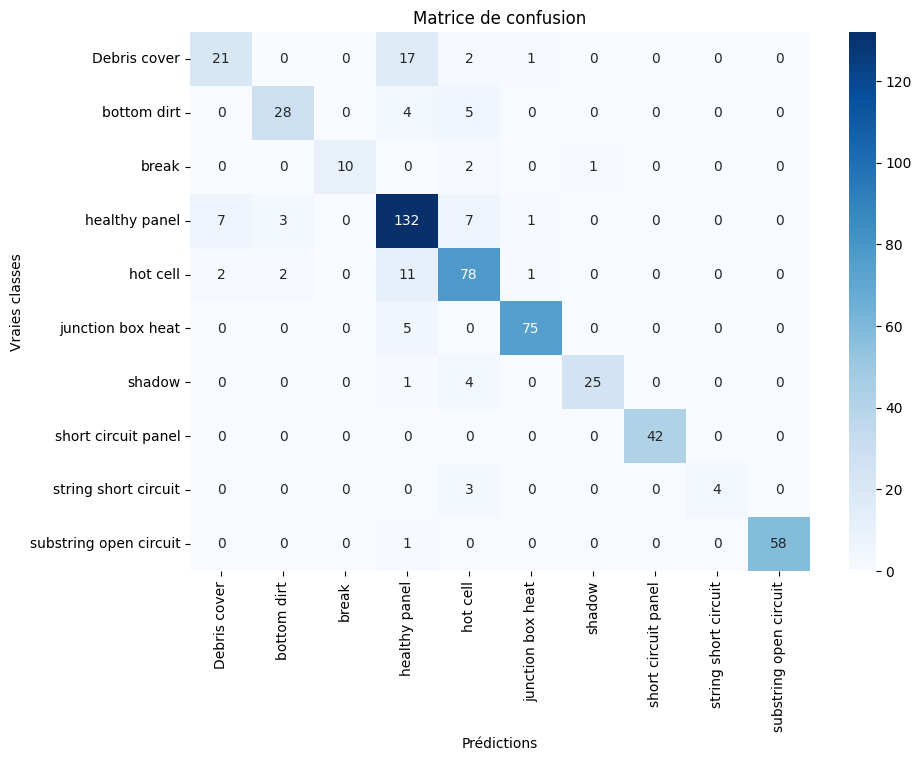

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.70      0.51      0.59        41
           bottom dirt       0.85      0.76      0.80        37
                 break       1.00      0.77      0.87        13
         healthy panel       0.77      0.88      0.82       150
              hot cell       0.77      0.83      0.80        94
     junction box heat       0.96      0.94      0.95        80
                shadow       0.96      0.83      0.89        30
   short circuit panel       1.00      1.00      1.00        42
  string short circuit       1.00      0.57      0.73         7
substring open circuit       1.00      0.98      0.99        59

              accuracy                           0.86       553
             macro avg       0.90      0.81      0.84       553
          weighted avg       0.86      0.86      0.85       553



In [14]:
# Pipeline finale = extraction des features HOG et pixels bruts + scaler + SVM
my_pipeline = ImbPipeline([
    ('features', FeatureUnion([
        ('hog', default_steps['hog']),
        ('brut',default_steps['brut'])
    ])),
    ('scaler', default_steps['scaler']),
    ('clf', SVC(kernel="rbf", gamma="scale",C=10,probability=True)) # Calcul des probas nécessaires pour l'interprétabilité
])

my_pipeline.fit(X_train,y_train)
evaluate_pipeline(my_pipeline,X_test,y_test)

# 9. Interprétabilité

On récupère les données d'entrée après les étapes d'extraction et de mise à l'échelle de la pipeline.

Nous allons étudier l'interprétabilité de ces données par le classifieur SVM de la pipeline.

In [39]:
# On récupère l'ensemble train après extraction et mise à l'échelle
sub_pipe = my_pipeline[:-1]
X_train_transformed = sub_pipe.transform(X_train)
X_train_transformed = pd.DataFrame(X_train_transformed,index = X_train.index,columns=sub_pipe.get_feature_names_out())
display (X_train_transformed)

# On récupère l'ensemble test après extraction et mise à l'échelle
X_test_transformed = sub_pipe.transform(X_test)
X_test_transformed = pd.DataFrame(X_test_transformed,index = X_test.index,columns=sub_pipe.get_feature_names_out())
display (X_test_transformed)

# On récupère le classifieur
clf = my_pipeline[-1]

,hog__HOG_1,hog__HOG_2,hog__HOG_3,hog__HOG_4,hog__HOG_5,hog__HOG_6,hog__HOG_7,hog__HOG_8,hog__HOG_9,hog__HOG_10,...,brut__Pixel411,brut__Pixel412,brut__Pixel413,brut__Pixel414,brut__Pixel415,brut__Pixel416,brut__Pixel417,brut__Pixel418,brut__Pixel419,brut__Pixel420
553,0.475736,0.110252,0.395382,0.172476,0.442123,0.195460,0.453316,0.393239,0.526852,0.568513,...,0.649351,0.653680,0.647826,0.643777,0.643777,0.653509,0.676724,0.712446,0.725738,0.743590
554,0.511323,0.470073,0.391776,0.175134,0.475677,0.144187,0.698277,0.482533,0.564409,0.347377,...,0.640693,0.632035,0.630435,0.605150,0.596567,0.653509,0.685345,0.725322,0.797468,0.807692
555,0.525323,0.079260,0.429578,0.722857,0.588923,0.344333,0.470425,0.325848,0.053404,0.492608,...,0.567100,0.580087,0.582609,0.583691,0.579399,0.565789,0.573276,0.562232,0.561181,0.581197
556,0.382701,0.167099,0.183664,0.460640,0.448264,0.617160,0.207273,0.299587,0.215579,0.153941,...,0.571429,0.580087,0.578261,0.536481,0.545064,0.539474,0.530172,0.549356,0.540084,0.521368
557,0.489704,0.076986,0.524581,0.566426,0.455293,0.127494,0.482850,0.620437,0.414504,0.435279,...,0.545455,0.558442,0.556522,0.566524,0.570815,0.565789,0.551724,0.557940,0.552743,0.572650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,0.570767,0.076247,0.069949,0.140876,0.531725,0.160996,0.173091,0.065813,0.466857,0.687638,...,0.229437,0.238095,0.239130,0.240343,0.236052,0.250000,0.254310,0.270386,0.278481,0.273504
5568,0.499801,0.115917,0.120023,0.208835,0.464813,0.218795,0.221043,0.147313,0.105398,0.334842,...,0.476190,0.467532,0.469565,0.463519,0.467811,0.473684,0.469828,0.480687,0.481013,0.512821
5569,0.447979,0.121411,0.155488,0.289991,0.280086,0.179734,0.081244,0.018724,0.029364,0.092946,...,0.406926,0.419913,0.417391,0.416309,0.424893,0.434211,0.435345,0.446352,0.447257,0.465812
5570,0.521596,0.047985,0.110887,0.039719,0.286975,0.113554,0.174974,0.000000,0.318815,0.645041,...,0.268398,0.268398,0.273913,0.283262,0.274678,0.271930,0.284483,0.283262,0.291139,0.303419


,hog__HOG_1,hog__HOG_2,hog__HOG_3,hog__HOG_4,hog__HOG_5,hog__HOG_6,hog__HOG_7,hog__HOG_8,hog__HOG_9,hog__HOG_10,...,brut__Pixel411,brut__Pixel412,brut__Pixel413,brut__Pixel414,brut__Pixel415,brut__Pixel416,brut__Pixel417,brut__Pixel418,brut__Pixel419,brut__Pixel420
0,0.526150,0.074309,0.058504,0.174420,0.489657,0.207759,0.130786,0.054362,0.551001,0.383824,...,0.670996,0.731602,0.921739,0.772532,0.690987,0.684211,0.681034,0.690987,0.679325,0.666667
1,0.192250,0.060638,0.165074,0.576505,0.565445,0.158623,0.119085,0.260391,0.475578,0.158207,...,0.316017,0.316017,0.443478,0.721030,0.446352,0.469298,0.551724,0.523605,0.518987,0.521368
2,0.241488,0.101324,0.245287,0.512957,0.485063,0.062868,0.080508,0.061279,0.025795,0.299444,...,0.692641,0.805195,0.956522,0.909871,0.755365,0.885965,0.900862,0.866953,0.814346,0.803419
3,0.291204,0.183035,0.168869,0.424433,0.428599,0.256474,0.066625,0.073241,0.028163,0.198359,...,0.619048,0.653680,0.786957,0.939914,0.811159,0.885965,0.913793,0.905579,0.898734,0.888889
4,0.209463,0.103228,0.144564,0.382589,0.501172,0.075075,0.013808,0.046103,0.000000,0.665130,...,0.718615,0.731602,0.943478,0.772532,0.690987,0.657895,0.663793,0.660944,0.628692,0.594017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548,0.507475,0.107880,0.109913,0.180762,0.472049,0.081596,0.021525,0.021703,0.000000,0.354657,...,0.662338,0.658009,0.665217,0.660944,0.665236,0.666667,0.655172,0.648069,0.632911,0.632479
549,0.322444,0.072877,0.240935,0.153396,0.370614,0.194006,0.145879,0.081908,0.208772,0.153528,...,0.567100,0.571429,0.573913,0.570815,0.575107,0.587719,0.590517,0.592275,0.582278,0.602564
550,0.589609,0.033039,0.161217,0.090893,0.549490,0.033899,0.086466,0.008402,0.008292,0.465279,...,0.554113,0.558442,0.556522,0.557940,0.553648,0.561404,0.556034,0.566524,0.552743,0.564103
551,0.703239,0.030184,0.066351,0.096802,0.656628,0.213007,0.105633,0.069542,0.014709,0.161988,...,0.593074,0.601732,0.617391,0.605150,0.600858,0.618421,0.594828,0.605150,0.586498,0.598291


Le classifieur SVM avec un noyau non linéaire ne permet pas une interprétabilité spécifique. Nous devons faire appel à une interprétabilité agnostique.

SHAP est beaucoup trop coûteux en calcul, étant donné le nombre de features que nous avons (plus de 2000). Nous utiliserons donc **LIME**. Par conséquent, il s'agira d'une interprétabilité locale et approximative.

In [40]:
import lime
import lime.lime_tabular

# On construit l'explainer LIME à partir de l'ensemble d'entraînement (transformé)
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_transformed.to_numpy(),
    training_labels=y_train,
    mode='classification',
    feature_names=X_train_transformed.columns,
    class_names=clf.classes_,
    random_state=42
)

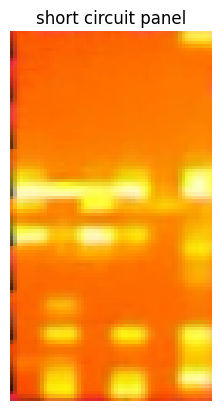

In [41]:
# On choisit une instance de test à expliquer
instance_idx = 80
img = cv2.imread(X_test.iloc[instance_idx]["Chemin"])
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(y_test[instance_idx])
plt.show()

d:\Sources\DS-projet\SEP24-CDS-PHOTOVOLTAIQUE\env\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


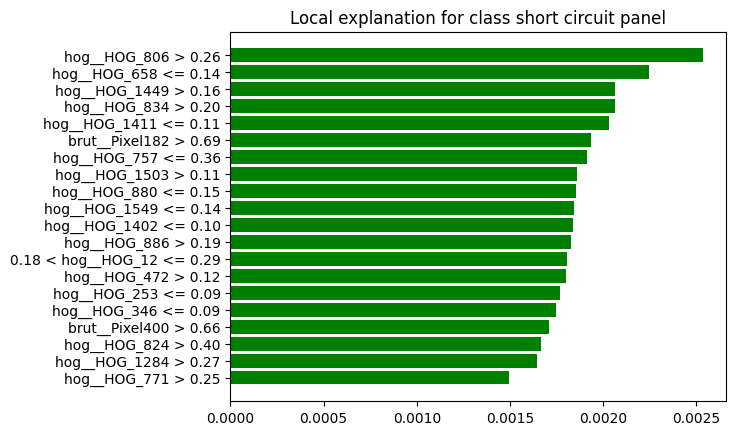

In [43]:
# Générer l'explication sur l'instance de test choisie (transformée)
explanation = explainer.explain_instance(
    data_row=X_test_transformed.iloc[instance_idx].to_numpy(),
    predict_fn= clf.predict_proba,
    num_features=20,
    labels=np.arange(len(clf.classes_))
)
# Afficher l'explication sous forme de graphique pour la classe prédite (celle avec la plus grande probabilité)
predicted_class_idx = np.argmax(clf.predict_proba(X_test_transformed.iloc[[instance_idx]]))
fig = explanation.as_pyplot_figure(label=predicted_class_idx)
plt.show()

Rmq : la classe prédite correspond bien ici à la classe réelle (short circuit panel)

Les vecteurs HOG sont plus utilisés que les pixels bruts pour expliquer la classe prédite. (18 parmi les 20 features les plus importantes)

Visualisons les cellules HOG correspondant aux **10 features HOG les plus importantes (HOG_806, HOG_658, etc.)**

Nombre de features HOG : 1701
Nombre de cellules : 9 (H) x 5 (L)


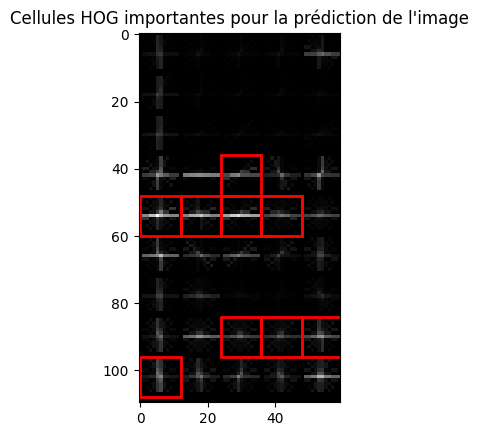

In [44]:
from skimage.feature import hog

# Extraction HOG avec les paramètres de la pipeline
pixels_per_cell = (12, 12)
cells_per_block = (3, 3)
orientations = 9
hog_features, hog_image = hog(
    cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),
    orientations=orientations,
    pixels_per_cell=pixels_per_cell,
    cells_per_block=cells_per_block,
    visualize=True,
    feature_vector=True
)
print(f"Nombre de features HOG : {hog_features.shape[0]}")

# Nombre de cellules HOG
n_cells_y = hog_image.shape[0] // pixels_per_cell[0]
n_cells_x = hog_image.shape[1] // pixels_per_cell[1]
print(f"Nombre de cellules : {n_cells_y} (H) x {n_cells_x} (L)")

# Index HOG les + importants (faire -1 par rapport au nom de la feature extraite)
hog_feature_idx = [805,657,833,1448,1410,756,879,1502,1548,885]

# N° de cellule HOG correspondants
cell_hog_idxs = [idx * n_cells_x * n_cells_y // len(hog_features) for idx in hog_feature_idx]

# Afficher l'image HOG et surligner les cellules trouvées
fig, ax = plt.subplots()
ax.imshow(hog_image, cmap='gray')

# Pour chaque n° de cellule HOG
for cell_hog_idx in cell_hog_idxs:
    # Calculer sa position dans l'image
    cell_row = cell_hog_idx // n_cells_x
    cell_col = cell_hog_idx % n_cells_x

    # Convertir en pixels
    rect_x = cell_col * pixels_per_cell[1]
    rect_y = cell_row * pixels_per_cell[0]

    # Dessiner un rectangle autour de la cellule
    rect = plt.Rectangle(
        (rect_x, rect_y),
        pixels_per_cell[1],
        pixels_per_cell[0],
        edgecolor='red',
        facecolor='none',
        linewidth=2
    )
    ax.add_patch(rect)

plt.title(f"Cellules HOG importantes pour la prédiction de l'image")
plt.show()

Plusieurs zones avec une forte variation de température semblent avoir eu une grande importance dans la détermination de cette image en "short circuit panel".

**2 pixels bruts (Pixel182 et Pixel400)** figuraient parmi les 20 features les plus importantes. Localisons-les sur l'image.

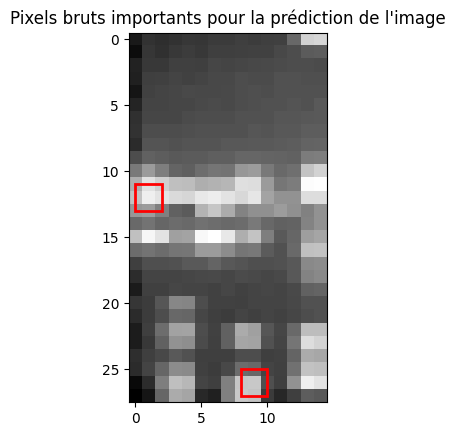

In [45]:
# Conversion de l'image en niveaux de gris et resizing conforme à l'extraction des pixels bruts de la pipeline
img_gray_resized = cv2.cvtColor(cv2.resize(img,(15,28)), cv2.COLOR_BGR2GRAY)

# Index des pixels les + importants (faire -1 par rapport au nom de la feature)
pixel_idxs = [181,399]

# Afficher l'image et entourer les pixels correspondants
fig, ax = plt.subplots()
ax.imshow(img_gray_resized, cmap='gray')

# Pour chaque n° de pixel identifié
for pixel_idx in pixel_idxs:
    # Calculer sa position dans l'image
    pix_row = pixel_idx // img_gray_resized.shape[1]
    pix_col = pixel_idx % img_gray_resized.shape[1]

    # Dessiner un rectangle autour du pixel
    rect = plt.Rectangle(
        (pix_col -1, pix_row -1),
        2,
        2,
        edgecolor='red',
        facecolor='none',
        linewidth=2
    )
    ax.add_patch(rect)

plt.title(f"Pixels bruts importants pour la prédiction de l'image")
plt.show()

Quelques pixels avec une intensité élevée semblent avoir eu de l'importance dans la détermination du short circuit.

Comme vu précédemment, ce sont néanmoins les gradients qui ont eu le plus de poids dans la décision de choisir cette classe de défaut.

# 10. Généralisation hors dataset

Voyons sur quelques images **hors dataset** si notre modèle arrive à détecter des défauts

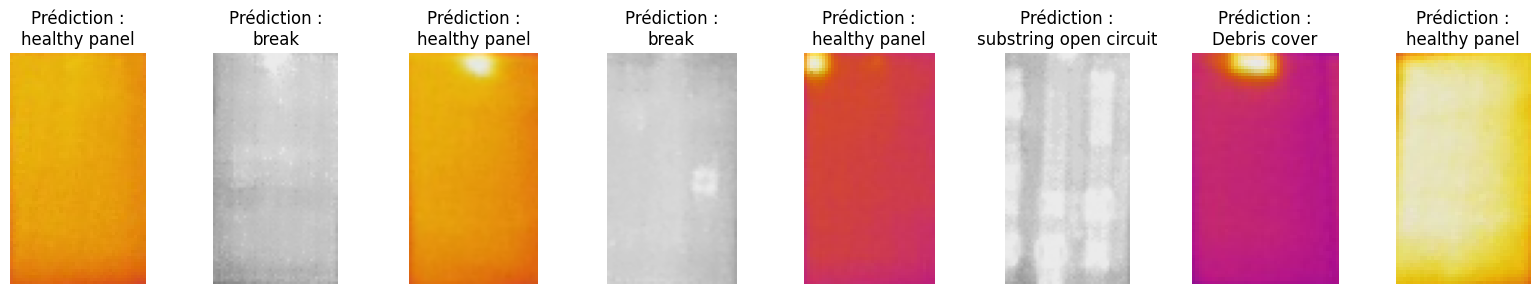

In [46]:
# Quelques images de test hors dataset pour la prédiction
plt.figure(figsize=(20, 3))
for i,unit_test_path in enumerate(["UT_images_ext/UT_healthy.png",
                                   "UT_images_ext/UT_junction_box.png",
                                   "UT_images_ext/UT_junction_box_2.png",
                                   "UT_images_ext/UT_one_cell.png",
                                   "UT_images_ext/UT_one_cell_2.png",
                                   "UT_images_ext/UT_multi_cell.png",
                                   "UT_images_ext/UT_multi_cell_2.png",
                                   "UT_images_ext/UT_module.png"]):
    unit_test = pd.DataFrame({"Chemin":[unit_test_path]})
    unit_pred = my_pipeline.predict(unit_test)
    plt.subplot(1, 8, i+1)
    img = cv2.imread(unit_test_path)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Prédiction :\n{unit_pred[0]}")
plt.show()

Le modèle arrive à détecter des défauts. Par contre, il classe 3 images healthy alors qu'elles ne le sont visiblement pas.


On touche là à la **limite identifiée au début du projet**. Le système d'acquisition, la construction d'images IR et l'environnement peuvent beaucoup varier d'une ferme photovoltaïque à l'autre. Même si notre dataset est issu de 8 fermes photovoltaïques différentes avec des conditions de prise d'images variées, il ne pourra être universellement efficace.

Faisons une manip simple de renforcement du contraste sur les 3 images prédites healthy à tort.

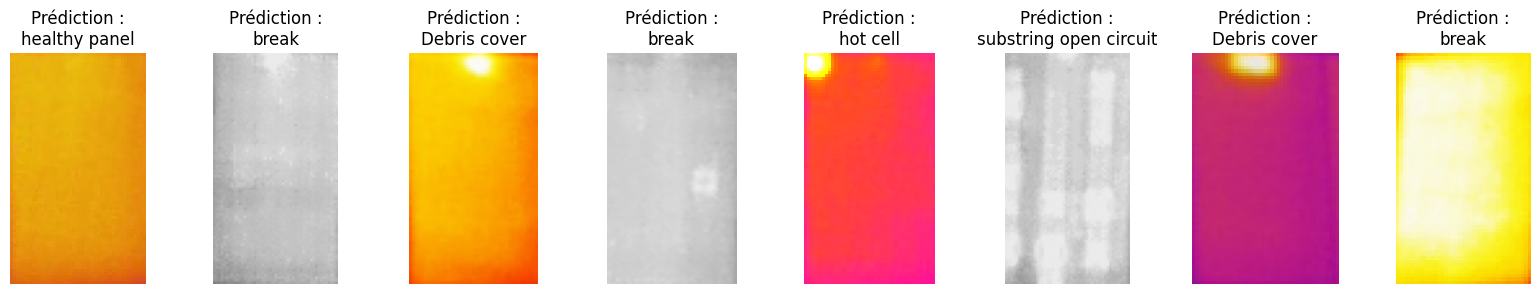

In [47]:
# Quelques images de test hors dataset pour la prédiction
plt.figure(figsize=(20, 3))
for i,unit_test_path in enumerate(["UT_images_ext_mod/UT_healthy.png",
                                   "UT_images_ext_mod/UT_junction_box.png",
                                   "UT_images_ext_mod/UT_junction_box_2.png",
                                   "UT_images_ext_mod/UT_one_cell.png",
                                   "UT_images_ext_mod/UT_one_cell_2.png",
                                   "UT_images_ext_mod/UT_multi_cell.png",
                                   "UT_images_ext_mod/UT_multi_cell_2.png",
                                   "UT_images_ext_mod/UT_module.png"]):
    unit_test = pd.DataFrame({"Chemin":[unit_test_path]})
    unit_pred = my_pipeline.predict(unit_test)
    plt.subplot(1, 8, i+1)
    img = cv2.imread(unit_test_path)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Prédiction :\n{unit_pred[0]}")
plt.show()

En renforçant le contraste, des défauts sont maintenant identifés sur les 3 panneaux en question.

Notre modèle est donc sensible à la manière dont sont construites les images.

### TODO

- Preprocessing : intégrer réduction de dimension (SelectKBest,PCA,LDA,UMAP...), intégrer rééchantillonnage (ROS, RUS, SMOTE, weight='balanced'...)
- Comparer les résultats si on retire en entrée les images 'Doute_Carre'
- Essayer d'autres modèles : KNN, RandomForest, MLPClassifier, modèles d'ensemble
- Interprétabilité des modèles : spécifique (coeff,feature_importance...) ou agnostique (permutation_importance, SHAP, LIME...)
- Question : part-on dès maintenant sur un ensemble train / val / test commun à tout le monde ?
    - Pour chaque modèle, ajuster ses hyperparamètres sur l'ensemble train par validation croisée (GridSearch,...)
    - Entraîner tous les modèles optimisés sur l'ensemble train et comparer leur résultat sur l'ensemble val
    - Entraîner le meilleur modèle sur train + val, et vérifier sa bonne généralisation sur test.